<a href="https://colab.research.google.com/github/8Raouf24/PFE/blob/master/RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Voici le notebook contenant le code du Filtrage collaboratif . On essaye de deviner la note donné par des utilisateurs aux articles d'Amazon qu'ils n'ont pas notés . Voici les étapes qui seront suivis :


1.   Charger les données et les transformer en DataFrame
2.   Pré-traitement des données pour faciliter le training
3.   Création du réseaux de neuronnes 
4.   Training du réseaux de neuronnes
5.   Recommandation








In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,callbacks
from pathlib import Path
from sklearn.metrics import r2_score
import gzip
import matplotlib.pyplot as plt
import json

Tout d'abord , nous téléchargons la base de données sur laquelle nous effectuerons nos travaux. Dans le cas échant nous utiliserons " Musical_Instruments_5" qui contient des articles d'Amazon appartenant a la catégorie " Instrument musical " ayant été noté par au moins 5  utilisateurs.

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Musical_Instruments_5.json.gz

--2020-08-19 19:49:29--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Musical_Instruments_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39356138 (38M) [application/octet-stream]
Saving to: ‘Musical_Instruments_5.json.gz’

Musical_Instruments 100%[===================>]  37.53M  14.3MB/s    in 2.6s    

2020-08-19 19:49:32 (14.3 MB/s) - ‘Musical_Instruments_5.json.gz’ saved [39356138/39356138]



In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Musical_Instruments.json.gz


--2020-08-19 19:49:34--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Musical_Instruments.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170266128 (162M) [application/octet-stream]
Saving to: ‘meta_Musical_Instruments.json.gz’

meta_Musical_Instru 100%[===================>] 162.38M  22.2MB/s    in 8.1s    

2020-08-19 19:49:42 (20.1 MB/s) - ‘meta_Musical_Instruments.json.gz’ saved [170266128/170266128]



Nous chargeons nos données depuis notre fichier json sous le format d'une liste afin de pouvoir faire la conversion vers un DataFrame.

In [ ]:
#Chargement des données sous le format liste
def vectorise(path):
  liste = []
  with gzip.open(path) as f:
      for l in f:
          liste.append(json.loads(l.strip()))
  return liste
    
data = vectorise('Musical_Instruments_5.json.gz')
# Nombre total de produit
print(len(data))

# Un exemple de produit
print(data[0])

231392
{'overall': 5.0, 'verified': True, 'reviewTime': '10 30, 2016', 'reviewerID': 'A3FO5AKVTFRCRJ', 'asin': '0739079891', 'reviewerName': 'francisco', 'reviewText': "It's good for beginners", 'summary': 'Five Stars', 'unixReviewTime': 1477785600}


Une fois notre Dataframe crée , nous le filtrerons afin de récolter les données pertinantes pour notre systéme de recommandation , c'est à dire les utilisateurs , les articles , et les ratings.

In [ ]:
#Transformation de nos données depuis le format liste vers le format dataframe
df = pd.DataFrame.from_dict(data)

data_dict = {'userID':df['reviewerID'],'itemID':df['asin'],'rating':df['overall']}
df_rs = pd.DataFrame.from_dict(data_dict)
df = df_rs

#Un exemple de ligne de notre dataframe
print(df_rs.iloc[0])

userID    A3FO5AKVTFRCRJ
itemID        0739079891
rating                 5
Name: 0, dtype: object


Ici , les prétraitements consisteront a transformer nos utilisateurs et nos articles en des indices d'entiers naturels.

In [ ]:
#Tout d'abord , nous recuillons les users de facon unique dans une liste
user_ids = df_rs["userID"].unique().tolist()
#Nous représentons chaque utilisateur de notre liste en un nombre entier et vice versa
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

#Meme travail pour les articles
item_ids = df_rs["itemID"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}

#Nous remplacons les colonnes de notre DF contenant les ID des utilisateurs et des articles sous format caractères par le format encodé en  nombre entier
df_rs["user"] = df_rs["userID"].map(user2user_encoded)
df_rs["item"] = df_rs["itemID"].map(item2item_encoded)

#Nous récupérons la taille des vecteurs des utilisateurs et articles
num_users = len(user2user_encoded)
num_items = len(item_encoded2item)

#Nous covnertissions les notes du format int au format float
df_rs["rating"] = df_rs["rating"].values.astype(np.float32)

#Le min et le max seront utilisés pour la normalisation un peu plus tard
min_rating = min(df_rs["rating"])
max_rating = max(df_rs["rating"])

print(
    "Number of users: {}, Number of Items: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_items, min_rating, max_rating
    )
)


Number of users: 27530, Number of Items: 10620, Min rating: 1.0, Max rating: 5.0


Nous préparons notre training et validation set

In [ ]:
#La fonction ci-dessous nous retourne une fraction de notre datafarme sous un ordre aléatoire
df_rs = df_rs.sample(frac=1, random_state=42)

#Nous définissons notre input ( liste de tuple user item)
x = df_rs[["user", "item"]].values


# On normalise notre target (le rating) pour faciliter le training
y = df_rs["rating"]#.apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# 70% du dataset sera utilisé pour le training et 30% pour la validation
train_indices = int(0.7 * df_rs.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)




Nous créeons notre modèle en vectorisant le vecteur d'un user et le vecteur d'un article en un seul vecteur de dimension 50.
Notre modèle calculera alors un score de correspondance  entre le vecteur de l'utilisateur et celui de l'article via un produit scalaire en ajoutant un biais par item et un biais par article . Le résultat sera entre un intervall de 0 et 1 via un sigmoid ( vu que nos ratings sont normalisés sur cette intervall)

In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        #Voici les inputs de notre modèle
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        """Nous utilisons l'API layers de keras pour invoquer la fonction Embedding 
        permettant de transformer des indices positifs en un vecteur dense de taille fixe (ce sera la premiere couche de notre réseau qui nous servira d'encoder )"""

        #On vectorise les user , Shape (None,27530,50)
        # (Numéro du user : int) ---> (vecteur[50])
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

        #On vectorise les items , Shape (None,10620,50)
        self.item_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )


        #Etant donné que le modèle est un modéle linéaire de forme item_embedding * user_embedding + items_bias + item_bias , nous devons définir les biais
        #Shape (None,10620,1)
        self.item_bias = layers.Embedding(num_items, 1)

        #Shape (None,10620,1)
        self.user_bias = layers.Embedding(num_users, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])

        #Nous effectuons le produit scalaire entre les vecteurs encodés des articles et des utilisateurs pour fusionner les deux layers
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)

        # nous ajoutons tout les composantes (y compris le biais)
        x = dot_user_item + user_bias + item_bias

        # La fonction d'activation sigmoid force le résultat a étre une valeur entre 0 et 1 (pour respecter notre normalisation)
        return x





In [ ]:
model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)


In [ ]:

#Ici nous utilisons l'optimiseur Adam (va variant on Stochastic Gradient Descent) qui altère l'embedding lors du training pour minimiser la perte qui est representé par Binary crossentropy
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(lr=1e-4),
     metrics=[tf.keras.metrics.RootMeanSquaredError(),"mae"])
es = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', mode='min', verbose=1, patience=10)


We train our model on the data split 

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=200,
    epochs=30,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[es],
)


Epoch 1/30
810/810 [==============================] - 12s 14ms/step - loss: 20.7720 - root_mean_squared_error: 4.5576 - mae: 4.4505 - val_loss: 20.5030 - val_root_mean_squared_error: 4.5280 - val_mae: 4.4204
Epoch 2/30
810/810 [==============================] - 11s 14ms/step - loss: 18.3932 - root_mean_squared_error: 4.2887 - mae: 4.1745 - val_loss: 18.9894 - val_root_mean_squared_error: 4.3577 - val_mae: 4.2457
Epoch 3/30
810/810 [==============================] - 11s 14ms/step - loss: 13.2875 - root_mean_squared_error: 3.6452 - mae: 3.5090 - val_loss: 14.7764 - val_root_mean_squared_error: 3.8440 - val_mae: 3.7138
Epoch 4/30
810/810 [==============================] - 11s 14ms/step - loss: 6.1235 - root_mean_squared_error: 2.4745 - mae: 2.3306 - val_loss: 9.1665 - val_root_mean_squared_error: 3.0275 - val_mae: 2.8854
Epoch 5/30
810/810 [==============================] - 11s 14ms/step - loss: 1.9101 - root_mean_squared_error: 1.3818 - mae: 1.2172 - val_loss: 6.0903 - val_root_mean_squa

PLot training , and validation rmse

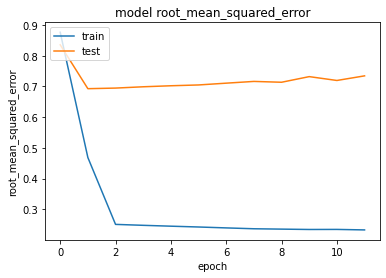

In [ ]:
plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
plt.title("model root_mean_squared_error")
plt.ylabel("root_mean_squared_error")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

source = "Building a Recommendation System Using Neural Network Embeddings" Will Kohersen

In [ ]:
model.save('/content/Keras_model/')

Epoch 1/100
810/810 [==============================] - 6s 8ms/step - loss: 20.7583 - root_mean_squared_error: 4.5551 - mae: 4.4470 - val_loss: 20.5454 - val_root_mean_squared_error: 4.5317 - val_mae: 4.4263
Epoch 2/100
810/810 [==============================] - 6s 8ms/step - loss: 18.2707 - root_mean_squared_error: 4.2730 - mae: 4.1568 - val_loss: 18.2917 - val_root_mean_squared_error: 4.2750 - val_mae: 4.1629
Epoch 3/100
810/810 [==============================] - 6s 8ms/step - loss: 11.8863 - root_mean_squared_error: 3.4444 - mae: 3.3007 - val_loss: 12.6176 - val_root_mean_squared_error: 3.5480 - val_mae: 3.4141
Epoch 4/100
810/810 [==============================] - 6s 8ms/step - loss: 4.3385 - root_mean_squared_error: 2.0740 - mae: 1.9241 - val_loss: 6.9293 - val_root_mean_squared_error: 2.6239 - val_mae: 2.4864
Epoch 5/100
810/810 [==============================] - 6s 8ms/step - loss: 1.5062 - root_mean_squared_error: 1.2074 - mae: 1.0007 - val_loss: 5.1786 - val_root_mean_squared_e

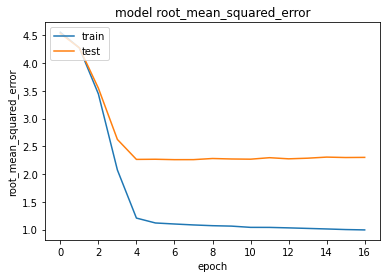

In [ ]:
EMBEDDING_SIZE = 50

#Augmentation de la regularization des embeddings

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        #Voici les inputs de notre modèle
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        """Nous utilisons l'API layers de keras pour invoquer la fonction Embedding 
        permettant de transformer des indices positifs en un vecteur dense de taille fixe (ce sera la premiere couche de notre réseau qui nous servira d'encoder )"""

        #On vectorise les user , Shape (None,27530,50)
        # (Numéro du user : int) ---> (vecteur[50])
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-4),
        )

        #On vectorise les items , Shape (None,10620,50)
        self.item_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-4),
        )


        #Etant donné que le modèle est un modéle linéaire de forme item_embedding * user_embedding + items_bias + item_bias , nous devons définir les biais
        #Shape (None,10620,1)
        self.item_bias = layers.Embedding(num_items, 1)

        #Shape (None,10620,1)
        self.user_bias = layers.Embedding(num_users, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])

        #Nous effectuons le produit scalaire entre les vecteurs encodés des articles et des utilisateurs pour fusionner les deux layers
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)

        # nous ajoutons tout les composantes (y compris le biais)
        x = dot_user_item + user_bias + item_bias

        # La fonction d'activation sigmoid force le résultat a étre une valeur entre 0 et 1 (pour respecter notre normalisation)
        return x



model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
#Ici nous utilisons l'optimiseur Adam (va variant on Stochastic Gradient Descent) qui altère l'embedding lors du training pour minimiser la perte qui est representé par Binary crossentropy
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(lr=1e-4),
     metrics=[tf.keras.metrics.RootMeanSquaredError(),"mae"])
es = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', mode='min', verbose=1, patience=10)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=200,
    epochs=100,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[es],
)


plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
plt.title("model root_mean_squared_error")
plt.ylabel("root_mean_squared_error")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


In [ ]:
EMBEDDING_SIZE = 50

#Ajout d'un dense layer supplémentaire de taille 64

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        #Voici les inputs de notre modèle
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        """Nous utilisons l'API layers de keras pour invoquer la fonction Embedding 
        permettant de transformer des indices positifs en un vecteur dense de taille fixe (ce sera la premiere couche de notre réseau qui nous servira d'encoder )"""

        #On vectorise les user , Shape (None,27530,50)
        # (Numéro du user : int) ---> (vecteur[50])
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-4),
        )

        #On vectorise les items , Shape (None,10620,50)
        self.item_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-4),
        )


        #Etant donné que le modèle est un modéle linéaire de forme item_embedding * user_embedding + items_bias + item_bias , nous devons définir les biais
        #Shape (None,10620,1)
        self.item_bias = layers.Embedding(num_items, 1)

        #Shape (None,10620,1)
        self.user_bias = layers.Embedding(num_users, 1)
        self.dense1 = layers.Dense(64)

    def call(self, inputs):

        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        x = tf.keras.layers.concatenate([user_vector,item_vector])
        x = self.dense1(x)

                              

        #Nous effectuons le produit scalaire entre les vecteurs encodés des articles et des utilisateurs pour fusionner les deux layers
        

        # nous ajoutons tout les composantes (y compris le biais)
        x = x + user_bias + item_bias

        # La fonction d'activation sigmoid force le résultat a étre une valeur entre 0 et 1 (pour respecter notre normalisation)
        return x



model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
#Ici nous utilisons l'optimiseur Adam (va variant on Stochastic Gradient Descent) qui altère l'embedding lors du training pour minimiser la perte qui est representé par Binary crossentropy
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(lr=1e-4),
     metrics=[tf.keras.metrics.RootMeanSquaredError(),"mae"])
es = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', mode='min', verbose=1, patience=10)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=200,
    epochs=100,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[es],
)

print(model.summary())
plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
plt.title("model root_mean_squared_error")
plt.ylabel("root_mean_squared_error")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


Epoch 1/100
810/810 [==============================] - 12s 15ms/step - loss: 19.8272 - root_mean_squared_error: 4.4514 - mae: 4.3407 - val_loss: 18.0067 - val_root_mean_squared_error: 4.2407 - val_mae: 4.1249
Epoch 2/100
810/810 [==============================] - 12s 15ms/step - loss: 15.3416 - root_mean_squared_error: 3.9107 - mae: 3.7709 - val_loss: 12.7477 - val_root_mean_squared_error: 3.5595 - val_mae: 3.3974
Epoch 3/100
810/810 [==============================] - 12s 15ms/step - loss: 10.1422 - root_mean_squared_error: 3.1668 - mae: 2.9568 - val_loss: 8.2434 - val_root_mean_squared_error: 2.8446 - val_mae: 2.5921
Epoch 4/100
810/810 [==============================] - 12s 15ms/step - loss: 6.4002 - root_mean_squared_error: 2.4920 - mae: 2.2080 - val_loss: 5.4429 - val_root_mean_squared_error: 2.2838 - val_mae: 1.9775
Epoch 5/100
810/810 [==============================] - 12s 15ms/step - loss: 4.1828 - root_mean_squared_error: 1.9804 - mae: 1.6759 - val_loss: 3.8178 - val_root_mean_

In [ ]:
model.save('.')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./assets


Epoch 1/300
810/810 [==============================] - 8s 10ms/step - loss: 19.8541 - root_mean_squared_error: 4.4544 - mse: 19.8419 - val_loss: 18.0549 - val_root_mean_squared_error: 4.2464 - val_mse: 18.0323
Epoch 2/300
810/810 [==============================] - 7s 9ms/step - loss: 15.4807 - root_mean_squared_error: 3.9285 - mse: 15.4333 - val_loss: 12.8523 - val_root_mean_squared_error: 3.5743 - val_mse: 12.7755
Epoch 3/300
810/810 [==============================] - 7s 9ms/step - loss: 10.5990 - root_mean_squared_error: 3.2383 - mse: 10.4868 - val_loss: 8.4478 - val_root_mean_squared_error: 2.8808 - val_mse: 8.2988
Epoch 4/300
810/810 [==============================] - 7s 9ms/step - loss: 7.2965 - root_mean_squared_error: 2.6668 - mse: 7.1116 - val_loss: 5.6898 - val_root_mean_squared_error: 2.3388 - val_mse: 5.4701
Epoch 5/300
810/810 [==============================] - 7s 9ms/step - loss: 5.4254 - root_mean_squared_error: 2.2750 - mse: 5.1754 - val_loss: 4.0678 - val_root_mean_squa

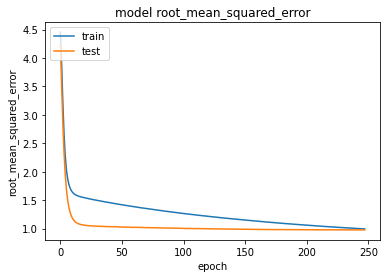

In [ ]:
EMBEDDING_SIZE = 50

#AJout d'un layer de taille 64 ainsi que d'un drop out

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        #Voici les inputs de notre modèle
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        """Nous utilisons l'API layers de keras pour invoquer la fonction Embedding 
        permettant de transformer des indices positifs en un vecteur dense de taille fixe (ce sera la premiere couche de notre réseau qui nous servira d'encoder )"""

        #On vectorise les user , Shape (None,27530,50)
        # (Numéro du user : int) ---> (vecteur[50])
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-4),
        )

        #On vectorise les items , Shape (None,10620,50)
        self.item_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-4),
        )


        #Etant donné que le modèle est un modéle linéaire de forme item_embedding * user_embedding + items_bias + item_bias , nous devons définir les biais
        #Shape (None,10620,1)
        self.item_bias = layers.Embedding(num_items, 1)

        #Shape (None,10620,1)
        self.user_bias = layers.Embedding(num_users, 1)
        self.dense1 = layers.Dense(128)
        

    def call(self, inputs):

        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        x = tf.keras.layers.concatenate([user_vector,item_vector])
        x = self.dense1(x)
        x = layers.Dropout(0.1)(x)


                              

        #Nous effectuons le produit scalaire entre les vecteurs encodés des articles et des utilisateurs pour fusionner les deux layers
        

        # nous ajoutons tout les composantes (y compris le biais)
        x = x + user_bias + item_bias

        # La fonction d'activation sigmoid force le résultat a étre une valeur entre 0 et 1 (pour respecter notre normalisation)
        return x

from keras import backend as K

def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
#Ici nous utilisons l'optimiseur Adam (va variant on Stochastic Gradient Descent) qui altère l'embedding lors du training pour minimiser la perte qui est representé par Binary crossentropy
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(lr=1e-4),
     metrics=[tf.keras.metrics.RootMeanSquaredError(),"mse"])
es = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', mode='min', verbose=1, patience=10)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=200,
    epochs=300,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[es],
)


plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
plt.title("model root_mean_squared_error")
plt.ylabel("root_mean_squared_error")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


In [21]:
model.save('.')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./assets


In [ ]:
meta_data = vectorise('meta_Musical_Instruments.json.gz')
# Nombre total de produit
print(len(meta_data))

# Un exemple de produit



In [ ]:
item_df = pd.DataFrame.from_dict(meta_data)
print(item_df.columns)
item_df.rename(columns = {'asin':'itemID'}, inplace = True)
print("\nafter modifications : \n",item_df.columns)


In [ ]:
print(df_rs.info())

Giving top 10 recommandations article for musical instruments :

In [32]:
user_id = df_rs.userID.sample(1).iloc[0]
items_reviewed_by_user = df_rs[df_rs.userID == user_id]
items_not_reviewed = item_df[
    ~item_df["itemID"].isin(items_reviewed_by_user.itemID.values)
]["itemID"]

print(items_not_reviewed)
items_not_reviewed = list(
    set(items_not_reviewed).intersection(set(item2item_encoded.keys()))
)
print(items_not_reviewed)


0         0000989983
1         0000098906
2         0041291905
3         0060015500
4         0193757710
             ...    
120305    B01HJDOF2Y
120306    B01HJDJ1PA
120307    B01HJEFFTK
120308    B01HJEHEH6
120309    B01HJETSF2
Name: itemID, Length: 120302, dtype: object
['B0049S1AJY', 'B00GQ5FQV6', 'B003YIXJTE', 'B00I9FL3OA', 'B00JA4T6RU', 'B000VTDE6W', 'B00L4KSL2Y', 'B010W6W8OW', 'B0083EKHVW', 'B00499G85Y', 'B003R6WRY6', 'B0071V3E9U', 'B00FN71R7U', 'B00IACBP36', 'B004ISLGKS', 'B014SATIAU', 'B00F3I43Q6', 'B005J3S1WW', 'B0007WPCKE', 'B00CP3GP5Y', 'B00I8QJWJI', 'B004THB6DA', 'B001U0OWSU', 'B009I4R4TY', 'B00MV840SC', 'B00F9DQXSG', 'B004M8R9J6', 'B00A2V9PW6', 'B0002GZNQI', 'B013LG9WQM', 'B001QYMM5A', 'B0002TKLI0', 'B0064RGHWI', 'B000RVZXSG', 'B0002CZV6O', 'B00TL5U56E', 'B0116TJA2C', 'B002IJK0HY', 'B0002OMOIU', 'B01G8Q2HSW', 'B003OSXND6', 'B01B50QVEC', 'B00JLY9UWA', 'B0018TJHO2', 'B00I056NYY', 'B00IT7JRVO', 'B00AMWO44O', 'B01H4VG35I', 'B00ISH3PYU', 'B001JJSP30', 'B004Z5GPSW', 'B0002KZIU

In [33]:
items_not_reviewed = [[item2item_encoded.get(x)] for x in items_not_reviewed]
print(items_not_reviewed)


[[4772], [7211], [4687], [7458], [10434], [2827], [7848], [8909], [5909], [4765], [10165], [5688], [10397], [7462], [4861], [9084], [10393], [10237], [1724], [6652], [7456], [5937], [4029], [6146], [7993], [7023], [4907], [10320], [1261], [9005], [3963], [1503], [10260], [2644], [152], [8490], [8920], [4299], [1473], [9743], [4608], [9464], [7672], [3422], [7411], [7560], [6263], [9788], [7551], [10095], [5070], [1373], [3924], [8048], [9358], [3973], [5098], [10251], [386], [8498], [6693], [1459], [4012], [1007], [3776], [5860], [7647], [10570], [1978], [2456], [8844], [8859], [2959], [8393], [10611], [1616], [6417], [2013], [420], [3264], [875], [426], [8142], [5582], [3196], [5645], [726], [6720], [2859], [538], [6597], [8615], [8371], [9825], [9128], [1726], [243], [10093], [2643], [1823], [8800], [5257], [9761], [6939], [5323], [8069], [9949], [6145], [6941], [7215], [3971], [55], [4460], [6645], [277], [3692], [3220], [7270], [2286], [2610], [3221], [7879], [231], [3906], [7851],

In [42]:
f = open('file.txt',"w")
for i in items_not_reviewed:
  f.write(str(i)+"\n")

In [ ]:
!cat file.txt

In [36]:
user_encoder = user2user_encoded.get(user_id)
user_item_array = np.hstack(
    ([[user_encoder]] * len(items_not_reviewed), items_not_reviewed)
)
print(user_item_array)

[[14433  4772]
 [14433  7211]
 [14433  4687]
 ...
 [14433  4615]
 [14433  3953]
 [14433  7562]]


In [48]:
ratings = model.predict(user_item_array).flatten()
print(ratings)
rating_item = list(zip(items_not_reviewed,ratings))
rating_item




[4.1661415 4.1623273 4.1653543 ... 4.3818917 4.3807073 4.3854313]


[([4772], 4.1661415),
 ([7211], 4.1623273),
 ([4687], 4.1653543),
 ([7458], 4.1628747),
 ([10434], 4.16353),
 ([2827], 4.1622925),
 ([7848], 4.1643314),
 ([8909], 4.1667395),
 ([5909], 4.164924),
 ([4765], 4.1657524),
 ([10165], 4.1626606),
 ([5688], 4.1601057),
 ([10397], 4.1651196),
 ([7462], 4.1631827),
 ([4861], 4.1651406),
 ([9084], 4.1656055),
 ([10393], 4.1626487),
 ([10237], 4.164682),
 ([1724], 4.16433),
 ([6652], 4.1668544),
 ([7456], 4.164601),
 ([5937], 4.164747),
 ([4029], 4.163108),
 ([6146], 4.164822),
 ([7993], 4.1639624),
 ([7023], 4.163274),
 ([4907], 4.162997),
 ([10320], 4.1638174),
 ([1261], 4.1646585),
 ([9005], 4.165464),
 ([3963], 4.1621037),
 ([1503], 4.1629496),
 ([10260], 4.1652803),
 ([2644], 4.164073),
 ([152], 4.1631722),
 ([8490], 4.1648417),
 ([8920], 4.1626353),
 ([4299], 4.1658826),
 ([1473], 4.1681156),
 ([9743], 4.165356),
 ([4608], 4.1625867),
 ([9464], 4.1636224),
 ([7672], 4.165415),
 ([3422], 4.1644096),
 ([7411], 4.1653237),
 ([7560], 4.1641154)

In [56]:
sorted_by_second = sorted(rating_item, key=lambda tup: tup[1])
top_10 = sorted_by_second[-10:-1]

In [57]:
res = [[ i for i, j in top_10 ], 
       [ j for i, j in top_10 ]] 

In [63]:
top_10_indices = res[0]
print(top_10_indices)

[[4694], [5522], [7940], [8938], [6890], [1022], [3443], [5102], [1744]]


In [64]:
top_ratings_indices = []
for i in top_10_indices:
  top_ratings_indices.append(i[0])


In [65]:
top_ratings_indices

[4694, 5522, 7940, 8938, 6890, 1022, 3443, 5102, 1744]

In [66]:
recommended_item_ids = [
    item_encoded2item.get(items_not_reviewed[x][0]) for x in top_ratings_indices
]

In [69]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Articles with high ratings from user")
print("----" * 8)
top_items_user = (
   items_reviewed_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .itemID.values
)
item_df_rows = item_df[item_df["itemID"].isin(top_items_user)]
for row in item_df_rows.itertuples():
    print(row.title, ":", row.category)

Showing recommendations for user: A3VSEMWFKF1QYY
Articles with high ratings from user
--------------------------------
D'Addario EXL120-7 Nickel Wound 7-String Electric Guitar Strings, Super Light, 9-54 : ['Musical Instruments', 'Instrument Accessories', 'Guitar & Bass Accessories', 'Strings', 'Electric Guitar Strings']
D'Addario EJ21 Nickel Wound Electric Guitar Strings, Jazz Light, 12-52 : ['Musical Instruments', 'Instrument Accessories', 'Guitar & Bass Accessories', 'Strings', 'Electric Guitar Strings']
D'Addario EXL120+ Nickel Wound Electric Guitar Strings, Super Light Plus, 9.5-44 : ['Musical Instruments', 'Instrument Accessories', 'Guitar & Bass Accessories', 'Strings', 'Electric Guitar Strings']
D'Addario EXL120-7 Nickel Wound 7-String Electric Guitar Strings, Super Light, 9-54 : ['Musical Instruments', 'Instrument Accessories', 'Guitar & Bass Accessories', 'Strings', 'Electric Guitar Strings']
D'Addario EJ21 Nickel Wound Electric Guitar Strings, Jazz Light, 12-52 : ['Musical In

In [73]:
print("----" * 8)
print("Top 10 articles recommendations")
print("----" * 8)
recommended_items = item_df[item_df["itemID"].isin(recommended_item_ids)]
for row in recommended_items.itertuples():
    print(row.title, ":", row.category)

--------------------------------
Top 10 articles recommendations
--------------------------------
Kaces 11-KB Xpress Series Keyboard Bag, 76-Key Large (51&quot; x 17.5&quot; x 6.5&quot;) : ['Musical Instruments', 'Instrument Accessories', 'Keyboard Accessories', 'Cleaning & Care']
Kaces 11-KB Xpress Series Keyboard Bag, 76-Key Large (51&quot; x 17.5&quot; x 6.5&quot;) : ['Musical Instruments', 'Instrument Accessories', 'Keyboard Accessories', 'Cleaning & Care']
Boss AC-3 Acoustic Simulator Pedal : ['Musical Instruments', 'Amplifiers & Effects', 'Guitar Effects', 'Electric Guitar Effects', 'Single Effects', 'Delay & Reverb']
Fender Pickup Switch Screws (12 PACK) : ['Musical Instruments', 'Instrument Accessories', 'Guitar & Bass Accessories', 'Electric Guitar Parts', 'Pickups & Pickup Covers']
Fender Pickup Covers, Jazzmaster - Aged White (2) : ['Musical Instruments', 'Instrument Accessories', 'Guitar & Bass Accessories', 'Electric Guitar Parts']
Yamaha YAC 1287 Standard Series 5C Alto S